# Práctico 2: Recomendación de videojuegos

En este práctico trabajaremos con un subconjunto de datos sobre [videojuegos de Steam](http://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data). Para facilitar un poco el práctico, se les dará el conjunto de datos previamente procesado. En este mismo notebook mostraremos el proceso de limpieza, para que quede registro del proceso (de todas maneras, por el tamaño de los datos no recomendamos que pierdan tiempo en el proceso salvo que lo consideren útil a fines personales). 

El conjunto de datos se basa en dos partes: lista de juegos (items), y lista de reviews de usuarios sobre distintos juegos. Este último, en su versión original es muy grande, (pesa 1.3GB), por lo que será solo una muestra del mismo sobre la que trabajarán.

A diferencia del conjunto de datos de LastFM utilizados en el [Práctico 1](./practico1.ipynb), en este caso los datos no están particularmente pensados para un sistema de recomendación, por lo que requerirá de un poco más de trabajo general sobre el dataset.

La idea es que, de manera similar al práctico anterior, realicen un sistema de recomendación. A diferencia del práctico anterior, este será un poco más completo y deberán hacer dos sistemas, uno que, dado un nombre de usuario le recomiende una lista de juegos, y otro que dado el título de un juego, recomiende una lista de juegos similares. Además, en este caso se requiere que el segundo sistema (el que recomienda juegos basado en el nombre de un juego en particular) haga uso de la información de contenido (i.e. o bien harán un filtrado basado en contenido o algo híbrido).

## Obtención y limpieza del conjunto de datos

El conjunto de datos originalmente se encuentra en archivos que deberían ser de formato "JSON". Sin embargo, en realidad es un archivo donde cada línea es un objeto de JSON. Hay un problema no obstante y es que las líneas están mal formateadas, dado que no respetan el estándar JSON de utilizar comillas dobles (**"**) y en su lugar utilizan comillas simples (**'**). Afortunadamente, se pueden evaluar como diccionarios de Python, lo cuál permite trabajarlos directamente.

In [1]:
!pip install scikit-surprise

In [1]:
import surprise

surprise.__version__

'1.1.0'

In [2]:
import pandas as pd
import io  # needed because of weird encoding of u.item file
import numpy as np


from surprise import KNNBaseline
from surprise import Dataset
from surprise import get_dataset_dir
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

## Conjunto de datos limpio

Para descargar el conjunto de datos que se utilizará en el práctico, basta con ejecutar la siguiente celda.

In [4]:
%%bash

mkdir -p data/steam/
curl -L -o data/steam/games.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/games.json.gz
curl -L -o data/steam/reviews.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/reviews.json.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1927k  100 1927k    0     0   737k      0  0:00:02  0:00:02 --:--:--  737k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  121M  100  121M    0     0  12.4M      0  0:00:09  0:00:09 --:--:-- 15.5M


## Ejercicio 1: Análisis Exploratorio de Datos

Ya teniendo los datos, podemos cargarlos y empezar con el práctico. Antes que nada vamos a hacer una exploración de los datos. Lo principal a tener en cuenta para este caso es que debemos identificar las variables con las que vamos a trabajar. A diferencia del práctico anterior, este conjunto de datos no está documentado, por lo que la exploración es necesaria para poder entender que cosas van a definir nuestro sistema de recomendación.

In [4]:
import pandas as pd

### Características del conjunto de datos sobre videojuegos

Las características del conjunto de datos de videojuegos tienen la información necesaria para hacer el "vector de contenido" utilizado en el segundo sistema de recomendación. Su tarea es hacer un análisis sobre dicho conjunto de datos y descartar aquella información redundante.

In [0]:
games = pd.read_json("./data/steam/games.json.gz")
games.head()

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,[Single-player],4.99,False,761140.0,Kotoshiro,None,None
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,None
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,None
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",0.83,[Single-player],0.99,False,767400.0,彼岸领域,None,None
4,None,None,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",1.79,"[Single-player, Full controller support, HTC V...",2.99,False,773570.0,None,None,None


In [0]:
games[games['app_name'].str.find('Age of')>-1]

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
220,Capcom,"[Casual, Strategy]",Age of Booty™,Age of Booty™,2009-03-09,"[Strategy, Casual, Pirates]",NaN,[Single-player],None,False,21600.0,Certain Affinity™,Mostly Negative,NA
506,Paradox Interactive,"[RPG, Strategy]",Age of Wonders II: The Wizard's Throne,Age of Wonders II: The Wizard's Throne,Oct 2010,"[Strategy, RPG, Turn-Based Strategy, Fantasy, ...",NaN,"[Single-player, Multi-player]",9.99,False,61510.0,Triumph Studios,Mostly Positive,86
509,Paradox Interactive,"[RPG, Strategy]",Age of Wonders Shadow Magic,Age of Wonders Shadow Magic,Oct 2010,"[Strategy, RPG, Turn-Based Strategy, Fantasy, ...",NaN,"[Single-player, Multi-player]",9.99,False,61520.0,Triumph Studios,Very Positive,82
510,Paradox Interactive,"[RPG, Strategy]",Age of Wonders,Age of Wonders,Oct 2010,"[Strategy, RPG, Turn-Based Strategy, Fantasy, ...",NaN,"[Single-player, Multi-player]",5.99,False,61500.0,Triumph Studios,Very Positive,None
1704,Microsoft Studios,[Strategy],Age of Empires II HD: The Forgotten,Age of Empires II HD: The Forgotten,2013-11-07,"[Strategy, RTS, Medieval, Multiplayer, Histori...",NaN,"[Single-player, Multi-player, Downloadable Con...",9.99,False,239550.0,"SkyBox Labs,Forgotten Empires",Very Positive,None
2641,ELYLAND INVESTMENT COMPANY LIMITED,"[Casual, Free to Play, Indie, Massively Multip...",My Lands: Age of Prosperity - Premium DLC Pack,My Lands: Age of Prosperity - Premium DLC Pack,2014-09-16,"[Strategy, Massively Multiplayer, Indie, Casua...",NaN,"[MMO, Co-op, Downloadable Content, Steam Achie...",19.99,False,316542.0,"Gravvit Ltd,Forbes Consult Ltd",None,None
2649,Triumph Studios,"[RPG, Strategy]",Age of Wonders III - Golden Realms Expansion,Age of Wonders III - Golden Realms Expansion,2014-09-18,"[Strategy, RPG, Fantasy, Turn-Based Strategy]",NaN,"[Single-player, Multi-player, Co-op, Shared/Sp...",11.99,False,299230.0,Triumph Studios,Very Positive,82
3361,Age of Fear,"[Indie, RPG, Strategy]",Age of Fear 2: The Chaos Lord GOLD,Age of Fear 2: The Chaos Lord GOLD,2015-03-27,"[RPG, Indie, Strategy, Turn-Based, Singleplaye...",NaN,"[Single-player, Multi-player, Local Multi-Play...",19.99,False,341150.0,Leslaw Sliwko,Very Positive,None
3681,Anarchy Enterprises,"[Casual, Indie, Simulation, Strategy]",Age of Castles: Warlords,Age of Castles: Warlords,2015-05-15,"[Casual, Simulation, Strategy, Indie]",NaN,"[Single-player, Steam Trading Cards]",1.99,False,371710.0,Anarchy Enterprises,Mostly Negative,None
3887,Age of Fear,"[Indie, RPG, Strategy]",Age of Fear: The Undead King,Age of Fear: The Undead King,2011-11-15,"[RPG, Indie, Strategy, Turn-Based, Singleplaye...",NaN,"[Single-player, Multi-player, Local Multi-Play...",19.99,False,351480.0,Leslaw Sliwko,Very Positive,None


#### Valores Nulos en el Dataset

In [0]:
pd.isna(games).sum()

publisher          8052
genres             3283
app_name              2
title              2050
release_date       2067
tags                163
discount_price    31910
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

#### Verificar app_name nula

In [0]:
games[games['app_name'].isnull()]

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
74,None,None,None,None,None,None,14.99,None,19.99,False,NaN,None,None,None
2580,None,"[Action, Indie]",None,None,2014-08-26,"[Action, Indie]",NaN,"[Single-player, Game demo]",None,False,317160.0,None,Positive,None


- El primer caso no se pudo encontrar los datos correspondientes al juego por lo que se elimina.
- Se buscó en la página https://store.steampowered.com/app/317160/_/ el nombre del juego con id 317160 y es DUET


In [0]:
games.loc[games.id == 317160.0, 'app_name'] = 'DUET'

In [0]:
games = games.drop(games[games['id'].isnull() & games['app_name'].isnull()].index)

#### Verificar los dos que tienen id nulo

In [0]:
games[games['id'].isnull()]

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,NaN,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


- En steam sale que el ID de este juego es 200260, por lo que hacemos verificacion para asegurar que no esta duplicado

In [0]:
games[games['id']==200260]

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
1068,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,200260.0,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


- Efecticamente está duplicado por lo que despues se hará verificación de la unicidad de los elementos.

#### Verificar tags y genres

In [0]:
games[games['tags'].isnull() & games['genres'].isnull()]

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
358,Paradox Interactive,None,Europa Universalis III: Heir to the Throne,Europa Universalis III: Heir to the Throne,2009-12-15,None,NaN,"[Single-player, Multi-player, Downloadable Con...",9.99,False,25806.0,Paradox Interactive,Positive,86
469,DnS Development,None,Booster Trooper Demo,Booster Trooper Demo,2010-08-31,None,NaN,[Game demo],None,False,27930.0,DnS Development,5 user reviews,None
612,"SEGA, Feral Interactive (Mac/Linux)",None,"Warhammer 40,000: Dawn of War II - Retribution...","Warhammer 40,000: Dawn of War II - Retribution...",2011-02-28,None,NaN,[Downloadable Content],0.99,False,56436.0,"Relic Entertainment,Feral Interactive (Mac/Linux)",3 user reviews,None
779,Trendy Entertainment,None,Dungeon Defenders Halloween Costume Pack,Dungeon Defenders Halloween Costume Pack,2011-11-11,None,NaN,[Downloadable Content],0.99,False,202520.0,Trendy Entertainment,9 user reviews,None
780,None,None,Dungeon Defenders Capture the Flag Pre-Alpha P...,Dungeon Defenders Capture the Flag Pre-Alpha P...,2011-11-11,None,NaN,[Downloadable Content],None,False,202523.0,Trendy Entertainment,Positive,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31181,"SEGA, Feral Interactive (Mac), Feral Interacti...",None,Total War: SHOGUN 2 - Sengoku Jidai Unit Pack,Total War: SHOGUN 2 - Sengoku Jidai Unit Pack,2011-07-28,None,NaN,[Downloadable Content],2.99,False,34342.0,"The Creative Assembly,Feral Interactive (Mac),...",4 user reviews,None
31262,Team17 Digital Ltd,None,"Worms Reloaded: The ""Pre-order Forts and Hats""...","Worms Reloaded: The ""Pre-order Forts and Hats""...",2011-05-17,None,NaN,[Downloadable Content],1.99,False,22630.0,Team17 Digital Ltd,7 user reviews,None
31273,"SEGA, Feral Interactive (Mac), Feral Interacti...",None,Total War: SHOGUN 2 - The Ikko Ikki Clan Pack,Total War: SHOGUN 2 - The Ikko Ikki Clan Pack,2011-05-26,None,NaN,[Downloadable Content],4.99,False,34348.0,"The Creative Assembly,Feral Interactive (Mac),...",3 user reviews,None
31324,Tripwire Interactive,None,"Killing Floor ""London's Finest"" Character Pack","Killing Floor ""London's Finest"" Character Pack",2010-12-14,None,NaN,[Downloadable Content],7.99,False,35419.0,Tripwire Interactive,Positive,None


import requests
import re
from simplejson import JSONDecodeError
import json
for index, records in games[games['tags'].isnull() & games['genres'].isnull()][:1].iterrows():
        
    response = requests.get(url = 'https://store.steampowered.com/app/'+str(int(215914)))
    print('https://store.steampowered.com/app/'+str(int(215914)))
    recomendation = re.search("GStoreItemData.AddStoreItemDataSet\(([^\)]+)\)", response.text, re.IGNORECASE)
    try:
        if recomendation:
            titles = recomendation.group(1)
            try:
                y = json.loads(titles)
            except JSONDecodeError as error:
                break
            print(y['rgApps'].keys())
            if len(y['rgApps']) != 0:
                for rec_id in list(y['rgApps'].keys()):
                    print(rec_id)
                    response = requests.get(url = 'https://store.steampowered.com/app/'+str(rec_id))
                    soup = BeautifulSoup(response.text, "html.parser")
                    try:

                        font = soup.find_all("a", href=re.compile("genre"),attrs={'class': None})
                        genre_list = []
                        for each_a in font:
                            genre_list.append(each_a.text)
                        print(genre_list)
                        break
                    except AttributeError as error:
                        print("No reco")
    except AttributeError as error:
        print("No <a> found")
        
    

#### Verificar Duplicidad

In [0]:
duplicated = games[games.duplicated('app_name',keep=False)].sort_values(by='app_name')

In [0]:
# creo un diccionarios de app_name con los id duplicados.
diccionario_dupli = {}
lista_dupli = []
for index,duplicated_game in duplicated.iterrows():
  if duplicated_game[2] in diccionario_dupli:
    diccionario_dupli[duplicated_game[2]].append(duplicated_game[10])
  else:
    diccionario_dupli[duplicated_game[2]] = [duplicated_game[10]]
  lista_dupli.append(duplicated_game[10])
print(diccionario_dupli)
      

{'AirMech® Soundtrack': [216173.0, 599520.0], 'Aliens: Colonial Marines - Reconnaissance Pack': [219441.0, 224850.0], 'Alter Ego': [63110.0, 664780.0], 'Altitude': [620010.0, 41300.0], 'Archangel': [553880.0, 661520.0], 'Batman: Arkham City - Game of the Year Edition': [200260.0, nan], 'Black Rose': [453890.0, 464510.0], 'Borealis': [307170.0, 565510.0], 'Castles': [666660.0, 384010.0], 'Colony': [509450.0, 720060.0], 'Dark Matter': [251410.0, 345130.0], 'Escape Room': [654070.0, 758210.0], 'Goro': [710270.0, 347890.0], 'Hero': [486020.0, 426460.0], 'Invasion': [622810.0, 397980.0], 'Invisible Apartment 2': [401200.0, 543220.0], 'Invisible Apartment Zero': [369120.0, 543230.0], 'Luna': [666810.0, 605770.0], 'MORE SWEATER? OK!': [746050.0, 773080.0], 'Mars 2030': [510850.0, 416070.0], 'New York Bus Simulator': [446480.0, 283580.0], 'Parasite': [464190.0, 434270.0], 'Prism': [617550.0, 443590.0], 'Puzzle Blocks': [501450.0, 747980.0], 'Rumpus': [542220.0, 458200.0], 'See No Evil': [46869

### Características del conjunto de datos de reviews

Este será el conjunto de datos a utilizar para obtener información sobre los usuarios y su interacción con videojuegos. Como se puede observar no hay un rating explícito, sino uno implícito a calcular, que será parte de su trabajo (deberán descubrir que característica les puede dar información que puede ser equivalente a un rating).

In [0]:
reviews = pd.read_json("./data/steam/reviews.json.gz")
reviews.head()

,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
0,SPejsMan,227940,0,Just one word... Balance!,23.0,92.0,2015-02-25,True,3159,None,NaN,NaN
1,Spodermen,270170,4,Graphics: none\nMusic: Makes me want to sleep\...,4.9,217.0,2014-08-26,False,231,None,NaN,7.656120e+16
2,josh,41700,1,"cheeki breeki iv danke, stalker",53.2,78.0,2015-12-25,False,191,None,NaN,NaN
3,Sammyrism,332310,9,I am really underwhelmed by the small about of...,16.2,178.0,2015-06-04,True,570,None,NaN,NaN
4,moonmirroir,303210,9,"I came into the game expecting nothing, of cou...",1.8,13.0,2015-10-02,False,967,None,NaN,NaN


- De este dataset vamos a considerar ***hours*** como el rating implicito del juego. Observamos que hay un total de 2442 usuarios que no ingresaron la cantidad de horas que jugaron el juego.

In [0]:
reviews[reviews.hours.isnull()]

,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
607,The Team Ranbir,228260,2,Stardock dropped the ball but looks pretty...a...,NaN,494.0,2013-08-12,False,117,None,NaN,NaN
716,Grind0r,374570,1,This is the best movie I have ever seen. It s...,NaN,62.0,2015-05-29,False,842,None,NaN,7.656120e+16
1002,Corpse,22330,2,Oblivion is easily in the top five games for m...,NaN,814.0,2013-06-02,False,826,None,NaN,NaN
1041,Mr.AFK,8980,8,"Great game, had loads of fun coop'ing it some ...",NaN,530.0,2012-12-30,False,942,None,NaN,NaN
1185,Hatano,374570,1,Movie of the year..!!!! I laugh for 30 min....,NaN,606.0,2015-05-30,False,672,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
697704,vertopci,208580,4,Quite possibly the greatest RPG ever made.,NaN,1065.0,2013-10-19,False,573,None,NaN,NaN
697983,camm68aro,353370,2,the controler is ok but nothing special. I hav...,NaN,126.0,2017-05-31,False,119,None,NaN,7.656120e+16
698469,Gem323,245550,2,good document with achivement ???,NaN,424.0,2015-08-15,False,54,None,NaN,NaN
698937,sbeam3,353370,1,Bought it with the steam link and it works gre...,NaN,206.0,2015-12-23,False,717,None,NaN,7.656120e+16


- Elegimos un usuario que no haya ingresado las horas de un juego, en este caso product_id==228260. Observamos la cantidad de horas que los otros usuarios jugaron.



In [0]:
reviews[reviews.product_id==228260].describe()

,product_id,page_order,hours,products,page,found_funny,user_id
count,98.0,98.000000,97.000000,98.000000,98.000000,11.000000,6.000000e+01
mean,228260.0,4.673469,81.240206,422.969388,63.785714,2.000000,7.656120e+16
std,0.0,2.917334,130.257428,535.562744,37.269774,1.183216,3.892150e+07
min,228260.0,0.000000,0.100000,5.000000,3.000000,1.000000,7.656120e+16
25%,228260.0,2.000000,16.200000,111.250000,29.500000,1.000000,7.656120e+16
50%,228260.0,5.000000,37.900000,253.000000,66.500000,2.000000,7.656120e+16
75%,228260.0,7.000000,105.200000,455.500000,97.750000,2.500000,7.656120e+16
max,228260.0,9.000000,1006.100000,3194.000000,124.000000,4.000000,7.656120e+16


### Distribucion de horas jugadas 

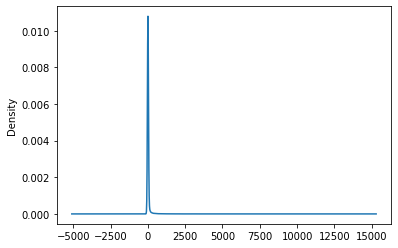

In [0]:
reviews = pd.read_json("./data/steam/reviews.json.gz")
reviews['hours'].value_counts().sort_index(ascending=False).plot(kind='kde')

### Distribucion de Juegos jugados

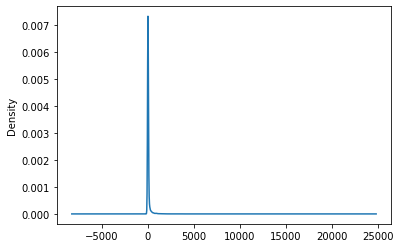

In [0]:
reviews.groupby('product_id')['hours'].count().plot(kind='kde')


In [0]:
reviews.groupby('product_id')['hours'].count().sort_values(ascending =False).reset_index()[:10]

,product_id,hours
0,440,16567
1,252490,9161
2,49520,6348
3,377160,6334
4,271590,5239
5,391540,5187
6,620,5056
7,221100,4901
8,230410,4692
9,319630,4638


In [0]:
mas_jugados = list(reviews.groupby('product_id')['hours'].count().sort_values(ascending =False).reset_index()[:10]['product_id'])
print(mas_jugados)
games[games['id'].isin(mas_jugados)][['app_name','id','genres']]

[440, 252490, 49520, 377160, 271590, 391540, 620, 221100, 230410, 319630]


,app_name,id,genres
632,Portal 2,620.0,"[Action, Adventure]"
4367,Undertale,391540.0,"[Indie, RPG]"
25017,Fallout 4,377160.0,[RPG]
26955,Grand Theft Auto V,271590.0,"[Action, Adventure]"
27507,Life is Strange - Episode 1,319630.0,"[Action, Adventure]"
29682,DayZ,221100.0,"[Action, Indie, Massively Multiplayer, Early A..."
29692,Rust,252490.0,"[Action, Adventure, Indie, Massively Multiplay..."
30274,Warframe,230410.0,"[Action, Free to Play]"
30746,Borderlands 2,49520.0,"[Action, RPG]"
31856,Team Fortress 2,440.0,"[Action, Free to Play]"


In [0]:
n_users = reviews.username.unique().shape[0]
n_items = reviews.product_id.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' items')

495383 users
11855 items


In [0]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['username'].nunique()
    N = df['product_id'].nunique()

    user_mapper = dict(zip(np.unique(df["username"]), list(range(M))))
    artist_mapper = dict(zip(np.unique(df["product_id"]), list(range(N))))
    
    #user_inv_mapper = dict(zip(list(range(M)), np.unique(df["username"])))
    #artist_inv_mapper = dict(zip(list(range(N)), np.unique(df["product_id"])))
    
    user_index = [user_mapper[i] for i in df['username']]
    item_index = [artist_mapper[i] for i in df['product_id']]

    X = csr_matrix((df["hours"], (user_index,item_index)), shape=(M,N))
    
    return X

reviews = pd.read_json("./data/steam/reviews.json.gz")
X = create_X(reviews)

In [0]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(n_total)
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

5872765465
Matrix sparsity: 0.01%


In [0]:
def print_pivot_table(ds):
  return pd.pivot_table(reviews[:100],values='hours',index='product_id',columns='username')


### Additional methods


In [4]:
def clean_game_df(games):
    games.loc[games.id == 317160.0, 'app_name'] = 'DUET'
    games = games.drop(games[games['id'].isnull() & games['app_name'].isnull()].index)
    return games

In [5]:
def normalizar(reviews):
    reviews['hours'] = reviews.apply(lambda row: row['hours']/reviews.groupby('username')['hours'].mean()[row['username']], axis =  1)
    return reviews

## Ejercicio 2 - Sistema de Recomendación Basado en Usuarios

Este sistema de recomendación deberá entrenar un algoritmo y desarrollar una interfaz que, dado un usuario, le devuelva una lista con los juegos más recomendados.

### User-Based Collaborative Filtering

In [6]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset

def read_item_names():
    games = pd.read_json("./data/steam/games.json.gz")
    games = clean_game_df(games)
    
    rid_to_name = {}
    name_to_rid = {}
    
    for index, line in games.iterrows():
        rid_to_name[line['id']] = line['app_name']

    return rid_to_name


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
reviews = pd.read_json("./data/steam/reviews.json.gz")
reviews = reviews[['username','product_id','hours']][:10000]
reviews = normalizar(reviews)
reviews['hours'] = pd.to_numeric(reviews['hours'], errors='coerce')
reviews = reviews.dropna(subset=['hours'])
reader = Reader(rating_scale=(reviews.hours.min(), reviews.hours.max()))
data = Dataset.load_from_df(reviews, reader)

trainset = data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': True}
print("Algo KNNBasic")
algo = KNNBasic(sim_options=sim_options, verbose=True)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)
read_id = read_item_names()
# Print the recommended items for each user
# Print the recommended items for each user


/users/slujan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Algo KNNBasic
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Games recommended for user 'Spodermen'

In [11]:
for (iid, _) in top_n['Spodermen']:
    print('\t'+(read_id[iid]))


	Heroes & Generals
	S.T.A.L.K.E.R.: Call of Pripyat
	LEGO® Worlds
	The Beginner's Guide
	METAL GEAR SOLID V: GROUND ZEROES
	Devil Daggers
	Total War™: ROME II - Emperor Edition
	Team Fortress 2
	Monsti
	Empire: Total War™


#### Se redujo el dataset porque me quedo sin memoria en COLAB

### Item-Based Collaborative Filtering

In [0]:
import io  # needed because of weird encoding of u.item file

from surprise import KNNBaseline
from surprise import Dataset
from surprise import get_dataset_dir
from surprise import Reader, Dataset

def read_item_names():
    """Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    """
    games = pd.read_json("./data/steam/games.json.gz")
    games = clean_game_df(games)
    
    rid_to_name = {}
    name_to_rid = {}
    
    for index, line in games.iterrows():
        rid_to_name[line['id']] = line['app_name']
        name_to_rid[line['app_name']] = line['id']

    return rid_to_name, name_to_rid

def get_top_n(game_user_name , k = 10, item=True):
    print("GET TOP N")
    # First, train the algortihm to compute the similarities between items
    
    print("Reading reviews")
    reviews = pd.read_json("./data/steam/reviews.json.gz")
    reviews = reviews[['username','product_id','hours']][:20000]
    reviews = normalizar(reviews)
    reviews['hours'] = pd.to_numeric(reviews['hours'], errors='coerce')
    reviews = reviews.dropna(subset=['hours'])
    reader = Reader(rating_scale=(reviews.hours.min(), reviews.hours.max()))
    
    data = Dataset.load_from_df(reviews, reader)
    trainset = data.build_full_trainset()
    sim_options = {'name': 'pearson_baseline', 'user_based': False}
    print("Creting KNNWithMeans")
    algo = KNNBasic(sim_options=sim_options, verbose=True)
    print(cross_validate(algo, data, measures=[ 'RMSE'], cv=3, verbose=True))
    print("Trainning")
    algo.fit(trainset)

    # Read the mappings raw id <-> movie name
    rid_to_name, name_to_rid = read_item_names()

    if item:
      artist_raw_id = name_to_rid[game_user_name]
      artist_inner_id = algo.trainset.to_inner_iid(artist_raw_id)

      print("Get neighbors")
      artist_neighbors = algo.get_neighbors(artist_inner_id, k=10)

      # Convert inner ids of the neighbors into names.
      artist_neighbors = (algo.trainset.to_raw_iid(inner_id)
                            for inner_id in artist_neighbors)
      artist_neighbors = (rid_to_name[rid]
                            for rid in artist_neighbors)

      print()
      print('The 10 nearest neighbors of {} are:', game_user_name)
      for artit in artist_neighbors:
          print(artit)
    else:
      inner_uid = algo.trainset.to_inner_uid(game_user_name)

      print("Get neighbors")
      games_neighbors = algo.get_neighbors(inner_uid, k=10)

      # Convert inner ids of the neighbors into names.
      artist_neighbors = (algo.trainset.to_raw_iid(inner_id)
                            for inner_id in artist_neighbors)
      artist_neighbors = (rid_to_name[rid]
                            for rid in artist_neighbors)

      print()
      print('The 10 nearest neighbors of {} are:', artist_name)
      for artit in artist_neighbors:
          print(artit)
      

In [0]:
get_top_n('Age of Empires II HD')

GET TOP N
Reading reviews


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Creting KNNWithMeans
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.1771  0.1910  0.2000  0.1894  0.0094  
Fit time          10.14   7.38    8.39    8.64    1.14    
Test time         0.05    0.04    0.04    0.05    0.00    
{'test_rmse': array([0.17709328, 0.19102033, 0.199975  ]), 'fit_time': (10.139121532440186, 7.3811140060424805, 8.388877391815186), 'test_time': (0.04727745056152344, 0.04490399360656738, 0.04320406913757324)}
Trainning
Estimating biases using als...
Computing the pearson_baseline similarity matrix...


/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:248: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Get neighbors

The 10 nearest neighbors of {} are: Age of Empires II HD
Heroes & Generals
Depression Quest
S.T.A.L.K.E.R.: Call of Pripyat
LEGO® Worlds
The Beginner's Guide
METAL GEAR SOLID V: GROUND ZEROES
Devil Daggers
Total War™: ROME II - Emperor Edition
Team Fortress 2
Monsti


### Look for best model 

In [0]:

reviews = pd.read_json("./data/steam/reviews.json.gz")
reviews = reviews[['username','product_id','hours']][:20000]
reviews = normalizar(reviews)
reader = Reader(rating_scale=(reviews.hours.min(), reviews.hours.max()))
reviews.info()

reviews['hours'] = pd.to_numeric(reviews['hours'], errors='coerce')
reviews = reviews.dropna(subset=['hours'])
print(reviews[reviews['hours'].isnull()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
username      20000 non-null object
product_id    20000 non-null int64
hours         19913 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 468.9+ KB
Empty DataFrame
Columns: [username, product_id, hours]
Index: []


In [0]:
import gc

data = Dataset.load_from_df(reviews, reader)
benchmark = []
# Iterate over all algorithms
for algorithm in [ KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=1)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    gc.collect()
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.1954  0.1889  0.2011  0.1951  0.0050  
Fit time          7.45    7.41    6.31    7.06    0.53    
Test time         0.05    0.05    0.05    0.05    0.00    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.1758  0.1950  0.1934  0.1881  0.0087  
Fit 

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBasic,0.188071,5.862327,0.073562
KNNBaseline,0.195145,7.060769,0.048031
BaselineOnly,0.195351,0.055391,0.036099
KNNWithZScore,0.287566,6.599291,0.048773
KNNWithMeans,0.291804,5.891868,0.047656


Best Algorithm KNNBasic

## Ejercicio 3 - Sistema de Recomendación Basado en Juegos

Similar al caso anterior, con la diferencia de que este sistema espera como entrada el nombre de un juego y devuelve una lista de juegos similares. El sistema deberá estar programado en base a información de contenido de los juegos (i.e. filtrado basado en contenido o sistema híbrido).

Basado en https://github.com/rounakbanik/movies/blob/master/movies_recommender.ipynb

### Games Description Based Recommender

In [36]:
reviews = pd.read_json("./data/steam/reviews.json.gz").head(25601)
games = pd.read_json("./data/steam/games.json.gz")
reviews.shape


(25601, 12)

In [37]:
reviews = reviews.merge(games, left_on='product_id', right_on='id', )

In [38]:
reviews['app_name'].unique()

array(['Heroes & Generals', 'Depression Quest',
       'S.T.A.L.K.E.R.: Call of Pripyat', ..., 'Knytt Underground',
       'Hunted: The Demon’s Forge™',
       'Dead Island: Riptide Definitive Edition'], dtype=object)

In [39]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25628 entries, 0 to 25627
Data columns (total 26 columns):
username          25628 non-null object
product_id        25628 non-null int64
page_order        25628 non-null int64
text              25628 non-null object
hours             25527 non-null float64
products          25584 non-null float64
date              25628 non-null datetime64[ns]
early_access_x    25628 non-null bool
page              25628 non-null int64
compensation      458 non-null object
found_funny       3934 non-null float64
user_id           10584 non-null float64
publisher         25306 non-null object
genres            25497 non-null object
app_name          25628 non-null object
title             25628 non-null object
release_date      25597 non-null object
tags              25628 non-null object
discount_price    42 non-null float64
specs             25503 non-null object
price             25427 non-null object
early_access_y    25628 non-null bool
id         

In [40]:
reviews['text'] = reviews['text'].fillna('')

In [41]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(reviews['text'])

In [42]:
tfidf_matrix.shape

(25628, 512037)

#### Cosine Similarity
I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two games. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [43]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [44]:
cosine_sim[0]

array([1.        , 0.05139855, 0.01114906, ..., 0.00944713, 0.00836567,
       0.        ])

We now have a pairwise cosine similarity matrix for all the movies in our dataset. 

In [45]:
reviews = reviews.reset_index()
product_ids = reviews['app_name']
indices = pd.Series(reviews.index, index=reviews['app_name'])

In [46]:
def get_recommendations(id):
    idx = indices[id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    product_indices = [i[0] for i in sim_scores]
    return list(product_ids.iloc[product_indices].head(10))
    

In [49]:
get_recommendations('Need For Speed: Hot Pursuit')

['Fallout 4',
 "Tom Clancy's Rainbow Six® Siege",
 'Undertale',
 'Borderlands 2',
 'Arma 3',
 'Life is Feudal: Your Own',
 'Pixel Piracy',
 'Brothers - A Tale of Two Sons',
 'Red Orchestra 2: Heroes of Stalingrad with Rising Storm',
 'Just Cause 2']

### Metadata Based Recommender

Dado que el recomendador basado en los comentarios no es bueno, realizamos otro basado en el genero, tags, publisher y developer. Como menciona el autor, esta es una solución bastante pobre pero en los resultados se ve que funciona bastante bien.
La idea es implementar un analisis de texto, y el texto es el resultado de la concatenacion del género, publisher, developer y tags.

In [85]:
games = pd.read_json("./data/steam/games.json.gz")
games.head()

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,[Single-player],4.99,False,761140.0,Kotoshiro,None,None
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,None
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,None
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",0.83,[Single-player],0.99,False,767400.0,彼岸领域,None,None
4,None,None,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",1.79,"[Single-player, Full controller support, HTC V...",2.99,False,773570.0,None,None,None


In [86]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 14 columns):
publisher         24083 non-null object
genres            28852 non-null object
app_name          32133 non-null object
title             30085 non-null object
release_date      30068 non-null object
tags              31972 non-null object
discount_price    225 non-null float64
specs             31465 non-null object
price             30758 non-null object
early_access      32135 non-null bool
id                32133 non-null float64
developer         28836 non-null object
sentiment         24953 non-null object
metascore         2677 non-null object
dtypes: bool(1), float64(2), object(11)
memory usage: 3.2+ MB


In [0]:
from ast import literal_eval
smd = pd.DataFrame()
smd['title'] = games['title']
smd['publisher'] = games['publisher'].astype(str).fillna('').apply(lambda x: str.lower(x.replace(" ", ""))).apply(lambda x: str.lower(x.replace("none", "")))
smd['genres'] = games['genres'].fillna('[]').astype(str)
smd['tags'] = games['tags'].fillna('[]').astype(str)
smd['developer'] = games['developer'].astype(str).fillna('').apply(lambda x: str.lower(x.replace(" ", ""))).apply(lambda x: str.lower(x.replace("none", "")))

In [88]:
smd

,title,publisher,genres,tags,developer
0,Lost Summoner Kitty,kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...","['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",kotoshiro
1,Ironbound,"makingfun,inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']","['Free to Play', 'Strategy', 'Indie', 'RPG', '...",secretlevelsrl
2,Real Pool 3D - Poolians,poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...","['Free to Play', 'Simulation', 'Sports', 'Casu...",poolians.com
3,弹炸人2222,彼岸领域,"['Action', 'Adventure', 'Casual']","['Action', 'Adventure', 'Casual']",彼岸领域
4,None,,[],"['Action', 'Indie', 'Casual', 'Sports']",
...,...,...,...,...,...
32130,Colony On Mars,ghost_rusgames,"['Casual', 'Indie', 'Simulation', 'Strategy']","['Strategy', 'Indie', 'Casual', 'Simulation']","nikita""ghost_rus"""
32131,LOGistICAL: South Africa,sacada,"['Casual', 'Indie', 'Strategy']","['Strategy', 'Indie', 'Casual']",sacada
32132,Russian Roads,laushstudio,"['Indie', 'Racing', 'Simulation']","['Indie', 'Simulation', 'Racing']",laushdmitriysergeevich
32133,EXIT 2 - Directions,sixnails,"['Casual', 'Indie']","['Indie', 'Casual', 'Puzzle', 'Singleplayer', ...","xropi,stev3ns"


In [0]:
smd['soup'] = smd['developer'] + smd['tags'] + smd['genres'] + smd['publisher']
smd['soup'] = smd['soup'].apply(lambda x: ''.join(x))

In [90]:
smd['soup']

0        kotoshiro['Strategy', 'Action', 'Indie', 'Casu...
1        secretlevelsrl['Free to Play', 'Strategy', 'In...
2        poolians.com['Free to Play', 'Simulation', 'Sp...
3        彼岸领域['Action', 'Adventure', 'Casual']['Action'...
4                ['Action', 'Indie', 'Casual', 'Sports'][]
                               ...                        
32130    nikita"ghost_rus"['Strategy', 'Indie', 'Casual...
32131    sacada['Strategy', 'Indie', 'Casual']['Casual'...
32132    laushdmitriysergeevich['Indie', 'Simulation', ...
32133    xropi,stev3ns['Indie', 'Casual', 'Puzzle', 'Si...
32134    ['Early Access', 'Adventure', 'Indie', 'Action...
Name: soup, Length: 32135, dtype: object

In [0]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [0]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)


In [0]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [0]:
def get_recommendations(id, titles, indices):
  print(id)
  idx = indices[id]
  print(idx)
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:31]
  product_indices = [i[0] for i in sim_scores]
  games_id_list = list(titles.iloc[product_indices].head(10))

  return games_id_list

In [101]:
get_recommendations('Counter-Strike', titles, indices)

Counter-Strike
32106


['Counter-Strike: Source',
 'Counter-Strike: Global Offensive',
 'Half-Life Deathmatch: Source',
 'Counter-Strike: Condition Zero',
 'Deathmatch Classic',
 'Half-Life 2: Deathmatch',
 'Team Fortress Classic',
 'ELEAGUE 2018 Boston CS:GO Major Championship Mega Bundle',
 'Day of Defeat',
 'Half-Life 2: Episode Two Soundtrack']

In [102]:
get_recommendations('Need For Speed: Hot Pursuit', titles, indices)

Need For Speed: Hot Pursuit
31327


['Burnout Paradise: The Ultimate Box',
 'The Crew™',
 'Test Drive Unlimited 2',
 'Need for Speed: Shift',
 'Need for Speed Undercover',
 'RaceRoom Racing Experience',
 'Woodle Tree 2: Worlds',
 'Sniper Fury',
 'Copa Petrobras de Marcas',
 'The Crew™ Season Pass']